In [10]:
""" !pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install tqdm
!pip install scipy
!pip install seaborn
!pip install gpytorch """

' !pip install torch\n!pip install torchvision\n!pip install matplotlib\n!pip install numpy\n!pip install pandas\n!pip install sklearn\n!pip install tqdm\n!pip install scipy\n!pip install seaborn\n!pip install gpytorch '

## ガウス回帰過程の実験



In [1]:
import numpy as np
import pandas as pd

# 乱数生成
np.random.seed(123) # 乱数のシードを固定
npoints = 3000 # データ数
x = np.random.normal(size=npoints)
z = np.random.normal(size=npoints)
y = np.sin(3 * np.power(x,3) + 2 * z*z + 0.05*np.random.normal(size=npoints))

# データフレームの作成
data = pd.DataFrame({'x': x, 'y': y, 'z': z})

# CSVファイルに保存
data.to_csv('data.csv', index=False)

### github copilot chatに入力したプロンプトと出力
>data.csvを読み込んで、yをターゲット、x,zをfeatureとしてガウス回帰過程で推定するプログラム例を示してください。GPytrochを用いてください。入力データをtraining用とtest用を分割してください。分布関数にはｔ分布を用いてください。損失のグラフを表示してください。test用データで予測値と誤差、実績値を散布図でグラフ化してください。

t分布は無視されました。。。損失のグラフ部分は修正しましたが、それ以外は特に問題がない例が出力されました。実行時にエラーは出ません。

numpyは利用されていませんが、importされているのはご愛嬌です。　

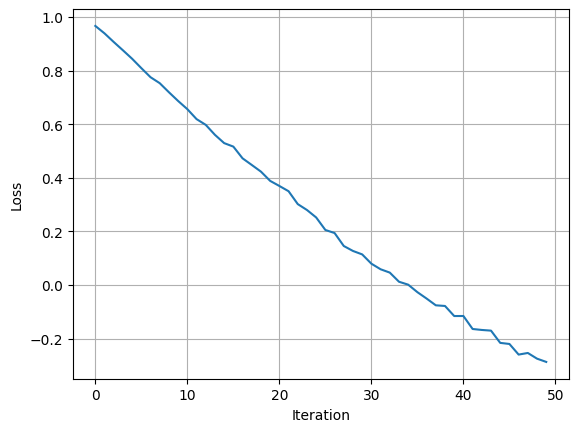

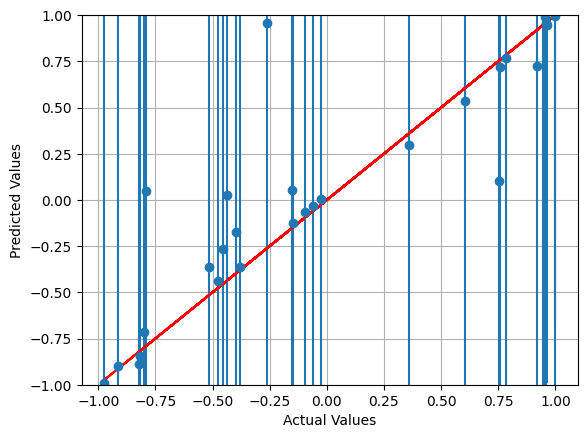

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gpytorch

# Load data from csv file
data = pd.read_csv('data.csv')

# Split data into training and test sets
train_data = data.sample(frac=0.99, random_state=1)
test_data = data.drop(train_data.index)

# Define feature and target columns
x_cols = ['x', 'z']
y_col = 'y'

# Convert data to torch tensors
train_x = torch.tensor(train_data[x_cols].values, dtype=torch.float)
train_y = torch.tensor(train_data[y_col].values, dtype=torch.float)
test_x = torch.tensor(test_data[x_cols].values, dtype=torch.float)
test_y = torch.tensor(test_data[y_col].values, dtype=torch.float)

# Define the Gaussian Process model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Train the model
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iterations = 50
losses = [] # 保存用
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Evaluate the model
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions on test data
    observed_pred = likelihood(model(test_x))
    pred_y = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    # Compute loss on test data
    test_loss = -mll(observed_pred, test_y)

# Plot the loss
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()  # グリッド線を表示
plt.show()

# Plot the predictions and actual values
plt.errorbar(test_y.numpy(), pred_y.numpy(), yerr=upper.numpy()-lower.numpy(), fmt='o')
plt.plot(test_y.numpy(), test_y.numpy(), 'r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.ylim([-1,1])
plt.grid()  # グリッド線を表示
plt.show()

In [3]:
import multiprocessing as mp

print(mp.cpu_count())

import torch

print(torch.cuda.is_available())

2
False
